In [ ]:
# -------------------------------------------
# LAB 6: Transfer Learning using Pre-trained CNN
# Object Detection / Image Classification (FAST VERSION)
# -------------------------------------------

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
# Step a: Load a pre-trained CNN model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Step b: Freeze lower convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Step c: Add custom classifier layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# 🔹 Use smaller subset to train faster (10k samples instead of 50k)
x_train_small = x_train[:10000]
y_train_small = y_train[:10000]
x_test_small = x_test[:2000]
y_test_small = y_test[:2000]

In [ ]:
# Data augmentation for better results
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train_small)

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step d: Train only the classifier head (quick 3 epochs)
print("\n🔹 Training custom classifier layers...")
model.fit(datagen.flow(x_train_small, y_train_small, batch_size=64),
          validation_data=(x_test_small, y_test_small),
          epochs=3, verbose=1)


🔹 Training custom classifier layers...
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 154s 969ms/step - accuracy: 0.2011 - loss: 2.2198 - val_accuracy: 0.4210 - val_loss: 1.7358
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.3664 - loss: 1.7940 - val_accuracy: 0.4690 - val_loss: 1.5531
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 152s 967ms/step - accuracy: 0.4202 - loss: 1.6585 - val_accuracy: 0.4830 - val_loss: 1.4814


In [ ]:
# Step e: Fine-tune - unfreeze last 4 convolutional layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
# Re-compile with smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Quick fine-tuning (2 epochs)
print("\n🔹 Fine-tuning last few layers...")
model.fit(datagen.flow(x_train_small, y_train_small, batch_size=64),
          validation_data=(x_test_small, y_test_small),
          epochs=2, verbose=1)


🔹 Fine-tuning last few layers...
Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.4861 - loss: 1.4927 - val_accuracy: 0.5515 - val_loss: 1.2643
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - accuracy: 0.5359 - loss: 1.3315 - val_accuracy: 0.5750 - val_loss: 1.1973


In [ ]:
# Evaluate model
loss, acc = model.evaluate(x_test_small, y_test_small, verbose=0)
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")


✅ Final Test Accuracy: 57.50%


In [ ]:
# Save model
model.save("transfer_learning_vgg16_fast.h5")
print("💾 Model saved successfully!")

💾 Model saved successfully!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Class labels for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Get model predictions
predictions = model.predict(x_test_small)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_small, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 400ms/step


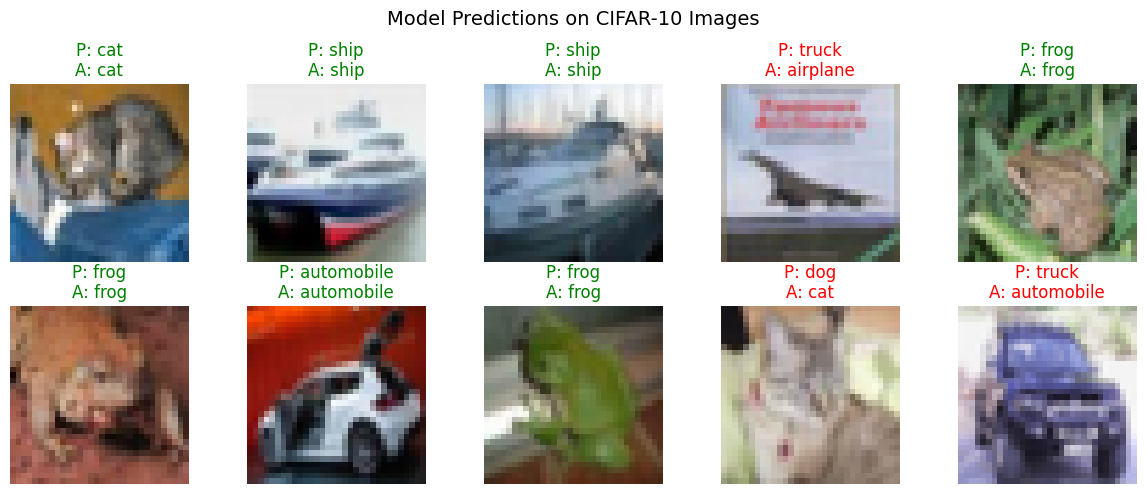

In [ ]:
# Display 10 test images with predicted vs actual labels
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_small[i])
    plt.axis('off')
    color = "green" if predicted_classes[i] == true_classes[i] else "red"
    plt.title(f"P: {class_names[predicted_classes[i]]}\nA: {class_names[true_classes[i]]}", color=color)
plt.suptitle("Model Predictions on CIFAR-10 Images", fontsize=14)
plt.tight_layout()
plt.show()